# Working with *concepts* in the Dimensions API
This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to extract `concepts` from documents and use them as the basis for more advanced topic-analysis tasks. 

In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [1]:
!pip install dimcli plotly -U --quiet 

import dimcli
from dimcli.utils import *
import json
import sys
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## 1. Background: What are `concepts`?


Concepts are normalized *noun phrases* describing the main topics of a document (see also the [official documentation](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts)). Concepts are automatically derived from documents abstracts using machine learning techniques, and are ranked based on their relevance. 

In the JSON data, concepts are available as an ordered list (=first items are the most relevant), including a relevance score. E.g. for the publications with ID 'pub.1122072646': 

```
{'id': 'pub.1122072646',
'concepts_scores': [{'concept': 'acid', 'relevance': 0.07450046286579201}, 
                    {'concept': 'conversion', 'relevance': 0.055053872555463006}, 
                    {'concept': 'formic acid', 'relevance': 0.048144671935356},
                    {'concept': 'CO2', 'relevance': 0.032150964737607}
                    [........]
                    ],
 }
```

Please note that (as of version 1.25 of the DSL API) it is possible to return either `concepts_scores` or `concepts` with Publications queries, but only `concepts` with Grants queries.  

### 1.1 From concepts to dataframes: Dimcli's `as_dataframe_concepts` method

A Dimensions API query normally returns a list of documents (publications, grants), where each document includes a list of concepts. 

In order to analyse concepts more easily, it is useful to 'unnest' concepts into a new structure where each concept is a top level item. In other words, we want to transform the original documents table into a concepts table. 

The [Dimcli](https://pypi.org/project/dimcli/) library provides a [method](https://api-lab.dimensions.ai/cookbooks/1-getting-started/3-Working-with-dataframes.html#4.-Dataframe-Methods-for-%E2%80%98Concepts%E2%80%99-queries) that does exactly that: `as_dataframe_concepts()`. 

In [2]:
q = """search publications for "graphene" 
            where year=2019 
       return publications[id+title+year+concepts_scores] limit 100"""
concepts = dsl.query(q).as_dataframe_concepts()
concepts.head(5)

Returned Publications: 100 (total = 116623)
Time: 1.06s


,id,title,year,concepts_count,concept,score,frequency,score_avg
0,pub.1129328198,Study of mechanochemistry of carbon nanotube u...,2019,6,study,0.088,31,0.21619
1,pub.1129328198,Study of mechanochemistry of carbon nanotube u...,2019,6,principles,0.047,2,0.13200
2,pub.1129328198,Study of mechanochemistry of carbon nanotube u...,2019,6,mechanochemistry,0.015,1,0.01500
3,pub.1129328198,Study of mechanochemistry of carbon nanotube u...,2019,6,first principles,0.012,1,0.01200
4,pub.1129328198,Study of mechanochemistry of carbon nanotube u...,2019,6,carbon nanotubes,0.010,6,0.38033


The `as_dataframe_concepts()`  method internally uses pandas to [explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html) the concepts list, plus it adds some extra metrics that are handy in order to carry out further analyses:

1. **concepts_count**: the total number of concepts for each single document. E.g., if a document has 35 concepts, concepts_count=35. 
2. **frequency**: how often a concept occur within a dataset, i.e. how many documents include that concept. E.g., if a concept appears in 5 documents, frequency=5.
3. **score**: the relevancy of a concept in the context of the document it is extracted from. Concept scores go from 0 (= not relevant) to 1 (= very relevant). NOTE if concepts are returned without scores, these are generated automatically by  normalizing its ranking against the total number of concepts for a single document. E.g., if a document has 10 concepts in total, the first concept gets a score=1, the second score=0.9, etc..
4. **score_avg**: the average (mean) value of all scores of a concept across multiple documents, within a given in a dataset. 

As we will see, by sorting and segmenting data using these parameters, it is possible to filter out common-name concepts and highlight more interesting ones. 

### 1.2 Extracting concepts from any text 

This tutorial focuses on concepts obtained from publications available via Dimensions. However, it is also possible to take advantage of Dimensions NLP infrastructure to extract concepts from any text. 

This can be achieved by using the DSL function [extract_concepts](https://docs.dimensions.ai/dsl/functions.html#extract-concepts) and passing an abstract-length text as an argument. 

For example:

In [3]:
abstract = """We describe monocrystalline graphitic films, which are a few atoms thick but are nonetheless stable under ambient conditions,
metallic, and of remarkably high quality. The films are found to be a two-dimensional semimetal with a tiny overlap between
valence and conductance bands, and they exhibit a strong ambipolar electric field effect such that electrons and
holes in concentrations up to 10 per square centimeter and with room-temperature mobilities of approximately 10,000 square
centimeters per volt-second can be induced by applying gate voltage.
""" 
res = dsl.query(f"""extract_concepts("{abstract}", return_scores=true)""")
pd.DataFrame(res['extracted_concepts'])

,concept,relevance
0,films,0.669
1,ambipolar electric field effect,0.653
2,two-dimensional semimetal,0.646
3,electric field effects,0.628
4,room temperature mobility,0.621
5,conductance band,0.601
6,graphitic films,0.596
7,field effects,0.596
8,centimeters,0.587
9,gate voltage,0.587


## 2. Data acquisition: retrieving publications and all their associated concepts 

Let's pull all publications from University College London classified with the FOR code "16 Studies in Human Society". 

> Tip: you can experiment by changing the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).


In [4]:
GRIDID = "grid.83440.3b" #@param {type:"string"}
FOR = "16 Studies in Human Society" #@param {type:"string"}
 
query = f"""
search publications 
    where research_orgs.id = "{GRIDID}"
    and category_for.name= "{FOR}"
    return publications[id+doi+concepts_scores+year]
"""

print("===\nQuery:\n", query)     
print("===\nRetrieving Publications.. ")
data = dsl.query_iterative(query)

Starting iteration with limit=1000 skip=0 ...


===
Query:
 
search publications 
    where research_orgs.id = "grid.83440.3b"
    and category_for.name= "16 Studies in Human Society"
    return publications[id+doi+concepts_scores+year]

===
Retrieving Publications.. 


0-1000 / 8650 (2.67s)
1000-2000 / 8650 (1.67s)
2000-3000 / 8650 (1.63s)
3000-4000 / 8650 (1.66s)
4000-5000 / 8650 (1.55s)
5000-6000 / 8650 (1.45s)
6000-7000 / 8650 (1.39s)
7000-8000 / 8650 (1.34s)
8000-8650 / 8650 (1.10s)
===
Records extracted: 8650


Let's turn the results into a dataframe and have a quick look at the data. You'll see a column `concepts_scores` that contains a list of concepts for each of the publications retrieved. 

In [5]:
pubs = data.as_dataframe()
pubs.head(5)

,concepts_scores,doi,id,year
0,"[{'concept': 'top managers', 'relevance': 0.86...",10.1016/j.erss.2021.102451,pub.1143924212,2022
1,"[{'concept': 'identity transitions', 'relevanc...",10.1016/j.cities.2022.103567,pub.1144750157,2022
2,"[{'concept': 'policy narratives', 'relevance':...",10.1016/j.envsci.2021.12.016,pub.1144322194,2022
3,"[{'concept': 'climate action', 'relevance': 0....",10.1016/j.spc.2021.12.011,pub.1143835100,2022
4,"[{'concept': 'African children', 'relevance': ...",10.1016/j.worlddev.2021.105739,pub.1142616152,2022


### 2.1 Processing concept data

Now it’s time to start digging into the ‘concepts’ column of publications.

Each publications has an associated **list** of concepts, so in order to analyse them we need to ‘explode’ that list so to have a new table with one row per concept.

In [6]:
concepts = data.as_dataframe_concepts()

print("===\nConcepts Found (total):", len(concepts))
print("===\nPreview:")
display(concepts)

===
Concepts Found (total): 343043
===
Preview:


,doi,id,year,concepts_count,concept,score,frequency,score_avg
0,10.1016/j.erss.2021.102451,pub.1143924212,2022,60,top managers,0.860,1,0.86000
1,10.1016/j.erss.2021.102451,pub.1143924212,2022,60,sustainability strategies,0.786,1,0.78600
2,10.1016/j.erss.2021.102451,pub.1143924212,2022,60,circular economy,0.765,6,0.56767
3,10.1016/j.erss.2021.102451,pub.1143924212,2022,60,company's sustainability strategy,0.741,1,0.74100
4,10.1016/j.erss.2021.102451,pub.1143924212,2022,60,top management perspective,0.738,1,0.73800
...,...,...,...,...,...,...,...,...
343038,10.1038/002374c0,pub.1032460376,1870,28,importance,0.018,388,0.29917
343039,10.1038/002374c0,pub.1032460376,1870,28,same subjects,0.017,1,0.01700
343040,10.1038/002374c0,pub.1032460376,1870,28,last month,0.015,1,0.01500
343041,10.1038/002374c0,pub.1032460376,1870,28,engineers,0.015,18,0.18028


If we ignore the publications metadata from the concepts list and drop duplicates, we can obtain a new table with **unique** concepts. 

In [7]:

concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']]
print("===\nUnique Concepts Found:", len(concepts_unique))
print("===\nPreview:")
display(concepts_unique)

===
Unique Concepts Found: 89485
===
Preview:


,concept,frequency,score_avg
0,top managers,1,0.86000
1,sustainability strategies,1,0.78600
2,circular economy,6,0.56767
3,company's sustainability strategy,1,0.74100
4,top management perspective,1,0.73800
...,...,...,...
343021,Indian Service,1,0.02800
343024,additional remarks,1,0.02600
343037,engineering colleges,1,0.02000
343039,same subjects,1,0.01700


## 3. Exploring our dataset: basic statistics about Publications / Concepts

In this section we'll show how to get an overview of the concepts data we obtained. 

These statistics are important because they will help us contextualize more in-depth analyses of the concepts data we'll do later on.

### 3.1 Documents With concepts VS Without 

You'll soon discover that not all documents have associated concepts (eg cause there's no text to extract them from, in some cases). 

Let's see how many:

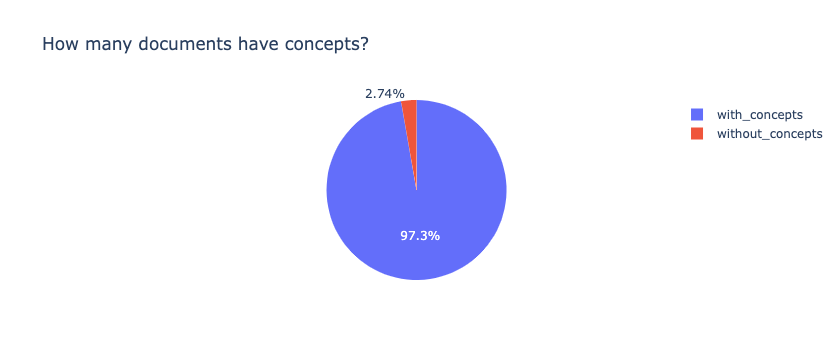

In [8]:
CONCEPTS_FIELD = "concepts_scores"

df = pd.DataFrame({
    'type': ['with_concepts', 'without_concepts'] ,
    'count': [pubs[CONCEPTS_FIELD].notnull().sum(), pubs[CONCEPTS_FIELD].isnull().sum()]
             })

px.pie(df, 
       names='type', values="count", 
      title = "How many documents have concepts?")

### 3.2 Yearly breakdown of Documents With concepts VS Without 

It's also useful to look at whether the ratio of with/without concepts is stable across the years. 

To this end we can use 
* the publications `id` column to count the total number of publications per year  
* the `concepts` column to count the ones that have concepts

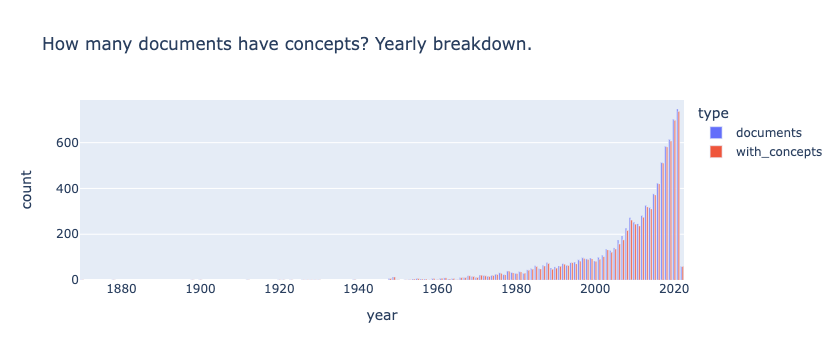

In [9]:
temp1 = pubs.groupby('year', as_index=False).count()[['year', 'id', CONCEPTS_FIELD]]
temp1.rename(columns={'id': "documents", CONCEPTS_FIELD: "with_concepts"}, inplace=True)

# reorder cols/rows
temp1 = temp1.melt(id_vars=["year"], 
         var_name="type", 
        value_name="count")

px.bar(temp1, title="How many documents have concepts? Yearly breakdown.",
       x="year", y="count", 
       color="type", 
       barmode="group")

### 3.3 Concepts frequency

It is useful to look at how many concepts appear more than once in our dataset. As you'll discovert, is often the case that only a subset of concepts appear more than once. That is because documents tend to be highly specialised hence a large number of extracted noun phrases aren't very common.

By looking at this basic frequency statistics we can determine a useful **frequency threshold** for our analysis - ie to screen out concepts that are not representative of the overall dataset we have. 

Tip: change the value of `THRESHOLD` to explore the data. 

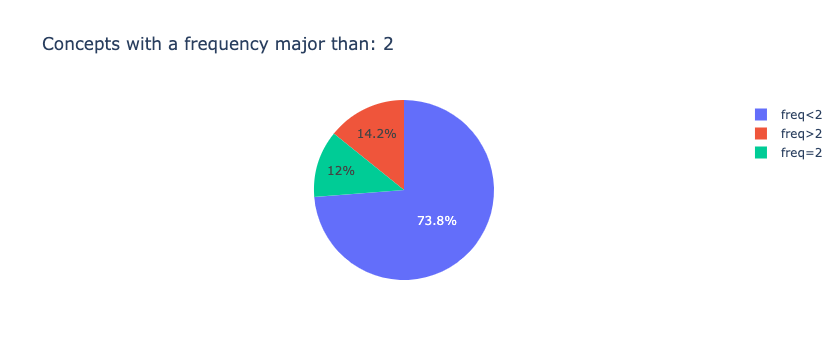

In [10]:
THRESHOLD = 2

df = pd.DataFrame({
    'type': [f'freq<{THRESHOLD}', 
             f'freq={THRESHOLD}',
             f'freq>{THRESHOLD}'] ,
    'count': [concepts_unique.query(f"frequency < {THRESHOLD}")['concept'].count(), 
              concepts_unique.query(f"frequency == {THRESHOLD}")['concept'].count(), 
              concepts_unique.query(f"frequency > {THRESHOLD}")['concept'].count()]
             })

px.pie(df, 
       names='type', values="count", 
      title = f"Concepts with a frequency major than: {THRESHOLD}")

### 3.4 Distribution of Concepts Frequency

It is useful to chart the overall distribution of how frequent concepts are. 

The bottom-left section of the chart shows the segment we are most likely to focus on, so to avoid concepts that appear only once, or the long-tail of highly frequent concepts that are likely to be common-words of little interest.

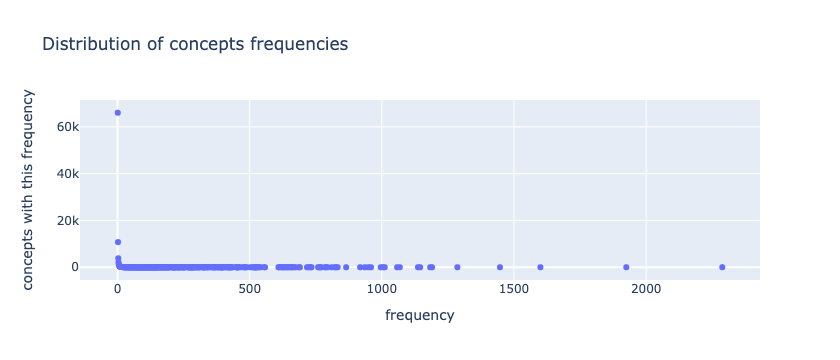

In [11]:
temp = concepts_unique.groupby('frequency', as_index=False)['concept'].count()
temp.rename(columns={'concept' : 'concepts with this frequency'}, inplace=True)
px.scatter(temp, 
           x="frequency", 
           y="concepts with this frequency",
          title="Distribution of concepts frequencies")

### 3.5 Yearly breakdown: unique VS repeated concepts

Also useful to look at the number of concepts per year, VS the number of unique concepts. 

This will give us a sense of whether the distribution of repeated concepts is stable across the years. 

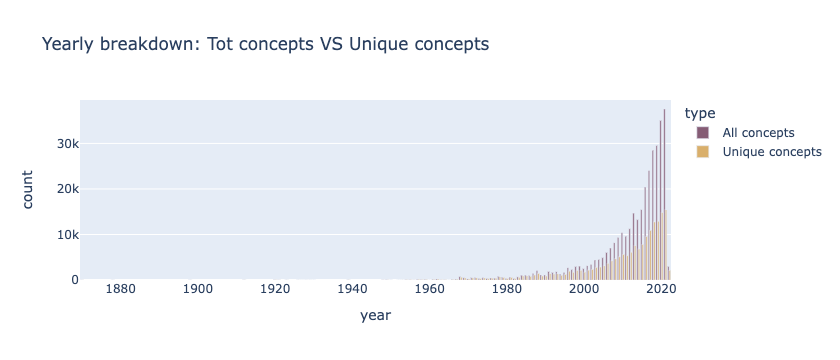

In [12]:
series1 = concepts.groupby("year")['concept'].count().rename("All concepts")
series2 = concepts.groupby("year")['concept'].nunique().rename("Unique concepts")
temp2 = pd.concat([series1, series2], axis=1).reset_index()
temp2 = temp2.melt(id_vars=["year"], 
         var_name="type", 
        value_name="count")

px.bar(temp2, 
       title="Yearly breakdown: Tot concepts VS Unique concepts",
       x="year", y="count", 
       color="type", barmode="group", 
       color_discrete_sequence=px.colors.carto.Antique)

## 4. Isolating 'interesting' concepts using `frequency` and `score_avg`

In this section we will take a deep dive into the concepts themselves, in particular by using the two metrics obtained above: `frequency` and `score_avg`. 

The main thing to keep in mind is that **only the combination of these two metrics can lead to interesting results**. In fact, if we used only *frequency* it'll lead to common keywords that are not very relevant; on the other hand, using only *relevancy* will result in concepts that important but just to one or two documents. 

### 4.1 The problem: frequent concepts are not *that* interesting!



For example, let's see what happens if we get the top concepts based on `frequency` only:

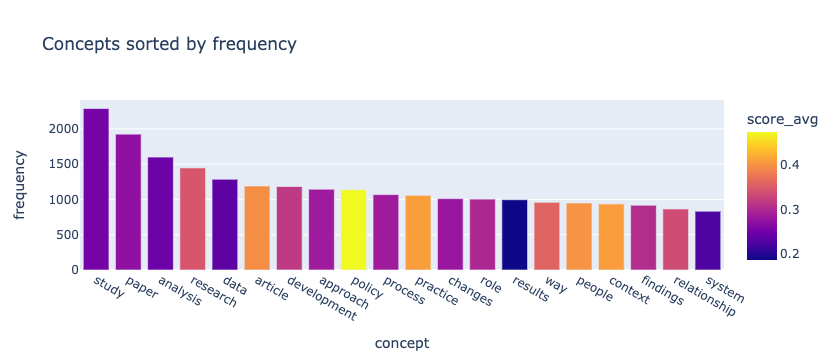

In [13]:
top = concepts_unique.sort_values("frequency", ascending=False)[:20]

px.bar(top, 
       title="Concepts sorted by frequency",
       x="concept", y="frequency", 
       color="score_avg")

Not very interesting at all! Those keywords are obviously very common (eg *study* or *development*) in the scientific literature, but of very little semantic interest. 

### 4.2 Solution 1: prefiltering by `score_avg` and sorting by `frequency`

By doing so, we aim at extracting concepts that are both frequent and tend to be very relevant (within their documents).   


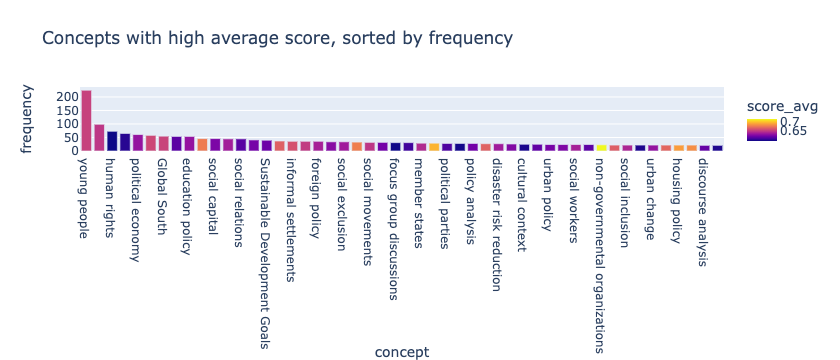

In [14]:
temp = concepts_unique.query("score_avg > 0.6").sort_values("frequency", ascending=False)

px.bar(temp[:50],
       title="Concepts with high average score, sorted by frequency",
       x="concept", y="frequency", 
       color="score_avg")

### 4.3 Solution 2: prefiltering by `frequency` and sorting by `score_avg`

This method also allows to isolate interesting concepts, even if they are not very frequently appearing in our dataset.  

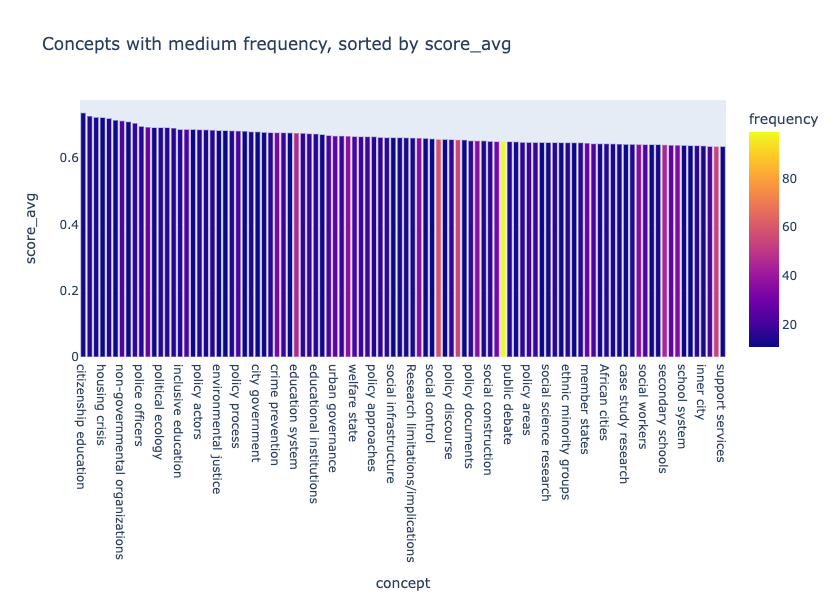

In [15]:
temp = concepts_unique.query("frequency > 10 & frequency < 100").sort_values(["score_avg", "frequency"], ascending=False)

px.bar(temp[:100], 
       title="Concepts with medium frequency, sorted by score_avg",
       x="concept", y="score_avg", 
       height=600,
       color="frequency")

## 5. Analyses By Year

In this section we will show how to use the methods above together with a yearly segmentation of the documents data. This will allow us to draw up some cool comparison of concepts/topics across years. 


### 5.1 Adding year-based metrics to the concepts dataframe

These are the steps

* recalculate *freq* and *score_avg* for each year, using the original concepts dataset from section 2.1 
* note this will result in duplicates (as many as the appearances of a concept within the same year), which of course we should remove 


In [16]:
concepts['frequency_year'] = concepts.groupby(['year', 'concept'])['concept'].transform('count')
concepts['score_avg_year'] = concepts.groupby(['year', 'concept'])['score'].transform('mean').round(5)

concepts_by_year = concepts.copy().drop_duplicates(subset=['concept', 'year'])\
                    [['year', 'concept', 'frequency_year', 'score_avg_year']]
concepts_by_year.head()

,year,concept,frequency_year,score_avg_year
0,2022,top managers,1,0.8600
1,2022,sustainability strategies,1,0.7860
2,2022,circular economy,2,0.6905
3,2022,company's sustainability strategy,1,0.7410
4,2022,top management perspective,1,0.7380


For example, let's look at the yearly-distribution of a specific concept: *migrants*

In [17]:
concepts_by_year[concepts_by_year['concept'] == "migrants"]

,year,concept,frequency_year,score_avg_year
77,2022,migrants,3,0.57400
3545,2021,migrants,15,0.48300
41207,2020,migrants,18,0.51656
76019,2019,migrants,13,0.56985
106285,2018,migrants,14,0.52993
133976,2017,migrants,10,0.49090
159012,2016,migrants,8,0.51450
178341,2015,migrants,6,0.52167
195937,2014,migrants,3,0.57400
211601,2013,migrants,3,0.58300


### 5.2 Charting the variation: multi-year visualization 

We can use Plotly's 'facets' to have subsections that show variation across years. Plotly will plot all the values retrieved - which allows to spot the trends up and down. 

* tip: to have an equal representation for each year, we take the top N concepts across a chosen years-span and then look at their frequency distribution over the years  

In order to isolate interesting concepts, we can use the same formula from above (filter by score, then sort by frequency). Only this time using yearly values of course!

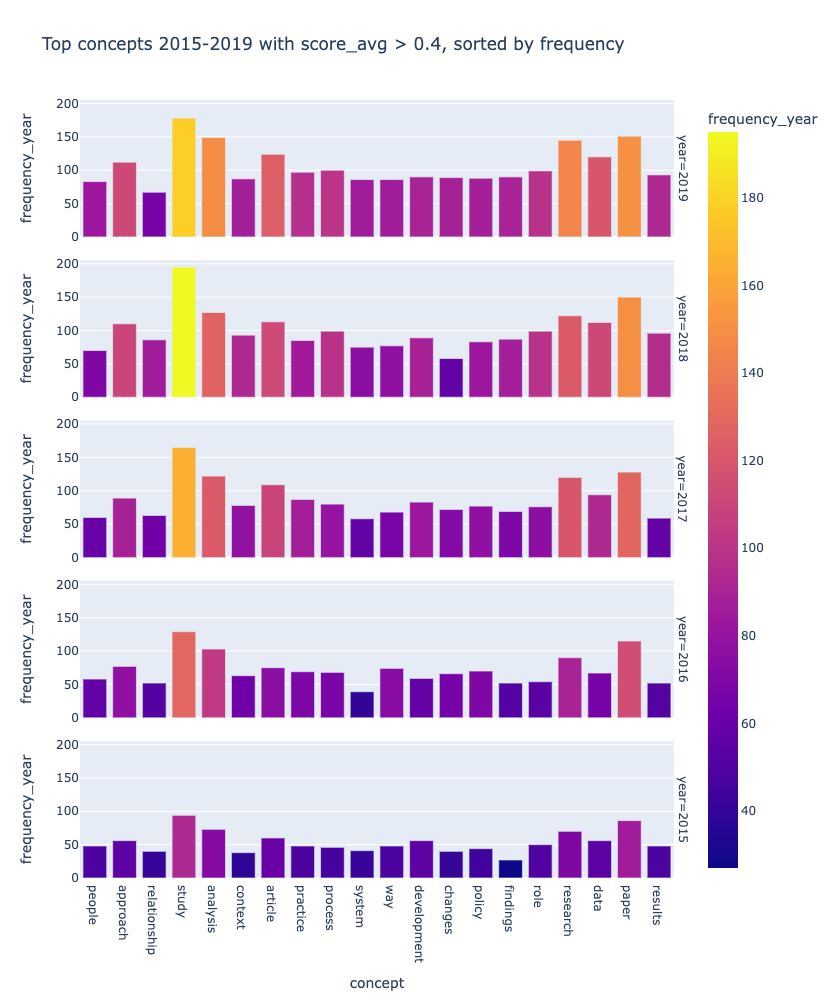

In [18]:
MAX_CONCEPTS = 50 
YEAR_START = 2015
YEAR_END = 2019
SCORE_MIN = 0.4

segment = concepts_by_year.query(f"year >= {YEAR_START} & year <= {YEAR_END}").copy()

# create metrics for the segment only
segment['frequency'] = concepts.groupby('concept')['concept'].transform('count')
segment['score_avg'] = concepts.groupby('concept')['score'].transform('mean').round(5)

# get top N concepts for the dataviz
top_concepts = segment.drop_duplicates('concept')\
        .query(f"score_avg > {SCORE_MIN}")\
        .sort_values("frequency", ascending=False)[:MAX_CONCEPTS]

# use yearly data only for top N concepts
segment_subset = segment[segment['concept'].isin(top['concept'].tolist())]

px.bar(segment_subset, 
       x="concept", 
       y="frequency_year", 
       facet_row="year",
       title=f"Top concepts {YEAR_START}-{YEAR_END} with score_avg > {SCORE_MIN}, sorted by frequency",
       height=1000,
       color="frequency_year")

## 6. Conclusion

In this tutorial we have demonstrated how to query for [concepts](https://docs.dimensions.ai/dsl/language.html#searching-using-concepts) using the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/). 

### The main takeaways

* concepts can be easily extracted by using the `as_dataframe_concepts()` method 
* concepts have an implicit score relative to the document they belong to - but we can create more absolute metrics by normalizing these scores 
* it is useful to look at the frequency of concepts in the context of the entire dataset we have
* there can be a long tail of concepts that are very infrequent, hence it's useful to filter those out
* by using a combination of frequency and score_avg metrics, we can filter out uninteresting concepts 


### What next

Using these methods, you can take advantage of *concepts* data in a number of real-world scenarios. Here are some ideas: 

* you can segment publications using other criteria: eg by *journal* or by *field of research*, in order to identify more specific trends; 
* concepts extracted can be used to create new DSL searches - using the `in concepts` [search syntax](https://docs.dimensions.ai/dsl/language.html#in-search-index);
* concepts data can be grouped further using [semantic similarity](https://spacy.io/usage/vectors-similarity) or [clustering](https://scikit-learn.org/stable/modules/clustering.html) techniques;
* you can look at the co-occurence of concepts withing the same document, in order to build a semantic network.
